In [1]:
% load_ext rpy2.ipython

In [82]:
%%R
library("phyloseq")
library(ggplot2)
library(stringr)

In [276]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [277]:
%%R
physeq = prune_samples(sample_sums(physeq)>5000, physeq)
otu_table(physeq) = transform_sample_counts(physeq, function(x) x / sum(x))

In [287]:
%%R
dist = distance(physeq, method="jaccard", weighted=TRUE)
# Okay, I have created the distance matrix.
# Now I want to compare the distance between my mineral samples and the soil samples

In [288]:
%%R
dim(as.matrix(dist))

[1] 51 51


In [289]:
%%R
dist = as.matrix(dist)
dist = dist[38:51,1:37]
# Needs to be adjusted depending on physeq pruning.

# This gives me the distance matrix of soil distance to each mineral.
# Now I want to group together all those where the microcosms are the same
# I can take each column, pull out the distance of this mineral to those soil samples
# Then, I need to get the cosm ID from each soil sample
# And I need to collect the cosm ID from the mineral sample
# My end goal is a table with the date, the mineral treatment, distance to a soil value, 
# and whether that distance is from the same cosm
# Month - Trtmt - Dist - SameCosm
# Then run ANOVA testing Dist ~ SameCosm + Trtmt + Month, etc.


In [290]:
%%R
Distance_summary = function(dist){
        total.info = data.frame(MTrtmt=factor(),MMonth=factor(),SMonth=factor(),MCosm=factor(),SCosm=factor(),Dist=numeric(),SameCosm=numeric())
        samples <- colnames(dist)
        soils <- rownames(dist)
        SameCosm = c()
    
        for (i in samples) {
            name = paste(i)
            MTrtmt = str_extract(name,"[A-Z]?")
            MMonth = str_extract(name,"[0-9]+[.]?[0-9]?")
            MCosm = str_extract(substring(name,nchar(name)-1,nchar(name)),"[0-9]{1,2}")
            sample.info = data.frame(MTrtmt=factor(),MMonth=factor(),SMonth=factor(),MCosm=factor(),SCosm=factor(),Dist=numeric(),SameCosm=numeric())
            for (j in soils) {
                sname = paste(j)
                SMonth = str_extract(sname,"[0-9]+[.]?[0-9]?")
                SCosm = str_extract(substring(sname,nchar(sname)-1,nchar(sname)),"[0-9]{1,2}")
                if (SCosm == MCosm) SameCosm=1 else SameCosm=0
                Dist = dist[j,i]
                distance.df = data.frame(MTrtmt,MMonth,SMonth,MCosm,SCosm,Dist,SameCosm)
                sample.info = rbind(sample.info,distance.df)
            }
            total.info = rbind(total.info,sample.info)
        }
    return(total.info)
}
# Extracts the 

In [291]:
%%R
dist.summ<-Distance_summary(dist)
dim(dist.summ)

[1] 518   7


In [292]:
%%R
dist.summ.samemonth <- dist.summ[dist.summ$MMonth==dist.summ$SMonth,]
dim(dist.summ.samemonth)

[1] 196   7


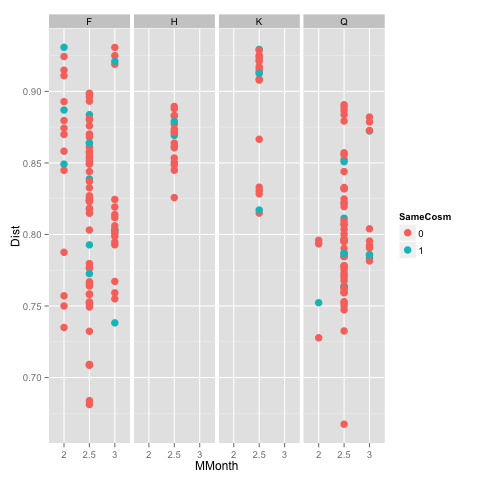

In [302]:
%%R
d = dist.summ.samemonth
d$SameCosm = as.factor(d$SameCosm)
p = ggplot(d, aes(x=MMonth, y=Dist, colour = SameCosm))
p = p  + geom_point(size=3.5)
p = p + facet_grid(~MTrtmt)
p

In [308]:
%%R
d = dist.summ.samemonth
d = d[d$MTrtmt==c("F","Q"),]
dist.aov = aov(data=d, Dist~MMonth+MTrtmt)
summary(dist.aov)

            Df  Sum Sq  Mean Sq F value Pr(>F)
MMonth       2 0.00940 0.004700   1.612  0.206
MTrtmt       1 0.00544 0.005443   1.867  0.176
Residuals   76 0.22155 0.002915               
